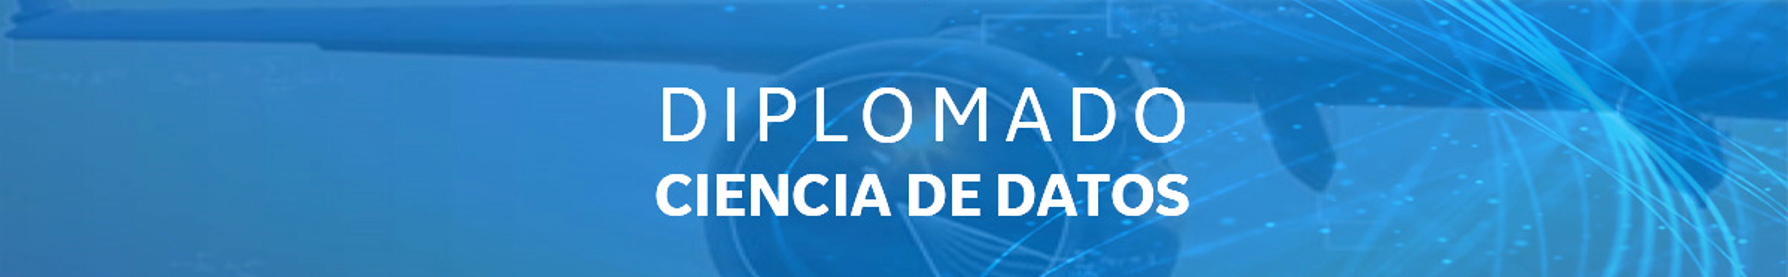

# Módulo 4 - Modelado en la Ciencia de Datos
## Panorama de métodos avanzados de clasificación

En este notebook se llevará a cabo un ejemplo para realizar la clasificación de imágenes utilizando redes neuronales.

Se revisará una arquitectura inicial, que después el alumno desarrollará más a fondo para mostrar las diferentes métricas de evaluación junto con algunas mejoras en desempeño respecto a este ejemplo inicial.

Como referencia para el alumno, este ejemplo es tomado de [tensor flow](https://www.tensorflow.org/tutorials/images/cnn).

## Cargar librerías necesarias

In [1]:
# # En caso de no tener tensorflow instalado, correr las siguiente líneas de código
# !pip install tensorflow

In [2]:
# # En caso de que no funcione la celda anterior, ejecutar las siguientes líneas de código
# import sys
# !{sys.executable} -m pip install tensorflow

In [16]:
tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [102]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Leer datos

#### Descripción de los datos

Los datos que se analizarán, contienen 60 mil imágenes a color para 10 clases diferentes. Este set de datos está balanceado, lo que quiere decir que cada clase tiene 6 mil imágenes. Por default, este set de datos viene dividido en 50 mil imágenes de entrenamiento y 10 mil de prueba.

#### Leer información

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Exploración de Datos

In [3]:
# Revisar cantidad de datos
train_images.shape

(50000, 32, 32, 3)

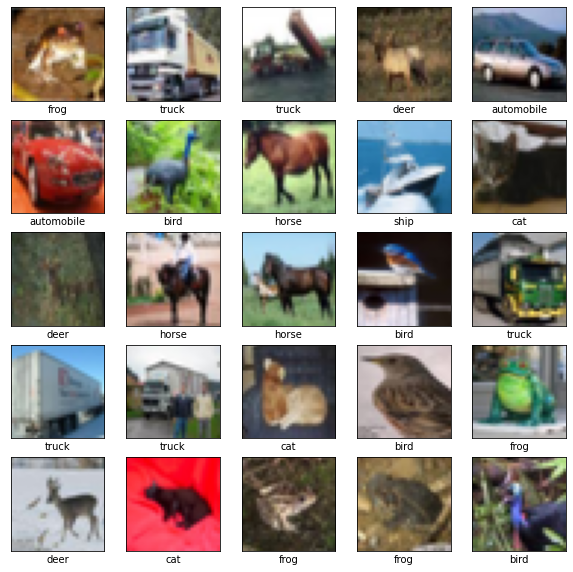

In [26]:
# Graficar los primeros 25 elementos del set de datos
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

# Pre-procesamiento

Existen algunos algoritmos para los cuales es necesario realizar una normalización inicial. Existen otros en los que no es estrictamente necesario, pero sí ayuda a que el procesamiento sea mucho más rápido.

Para el caso de las redes neuronales, nos aseguraremos de que las imagenes estén normalizadas en un rango de 0 a 1.

In [11]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

In [4]:
# Dividimos los arreglos de las imagenes entre 255, que es la escala que maneja RGB de acuerdo a la intensidad de cada uno de los colores (rojo, verde, azul)
train_images, test_images = train_images / 255.0, test_images / 255.0

# Configuración y ejecución del modelo

Las redes neuronales convolucionales (_Convolutional Neural Networks_ - CNN) son principalmente utilizadas en procesamiento de imágenes, aunque también se pueden usar para otros tipos de entradas, como de audio.

En este caso, se realizará la configuración de la red basada en recomendaciones generales sobre la arquitectura de CNN, pero es importante considerar que se tiene libertad a la hora de ensamblar las diferentes capas.

Algunos conceptos a considerar son los siguientes tipos de capas en la red:
1. Capa convolucional (Ej. Conv2D): Produce un tensor de salidas cuyo propósito principal es detectar ciertas características (_features_) o patrones de la imagen. Algunos de los parámetros importantes para esta capa son el número de filtros (o kernels), el tamaño de los kernels (ancho x altura), y la función de activación.
2. Capa de pooling (Ej. MaxPooling2D): El propósito principal de este tipo de capa es reducir las dimensiones del arreglo, que se logra tomando el máximo valor dentro de una ventana con un tamaño especificado (_pool_size_) para cada uno de los canales de la entrada.
3. Capa de aplanamiento (Ej. Flatten): Coloca los arreglos en una misma dimensión (comúmente referido como aplanar).
4. Capa de densamente conectada (Ej. Dense): En este tipo de capa se realizan las conexiones de cada una de las neuronas de la capa anterior con las neuronas de salida. La cantidad de neuronas de salida está dada por una selección (_units_). Cuando se habla de conexiones, quiere decir que cada neurona de salida está dada por el resultado de aplicar la función de activación a la suma del producto de cada neurona de entrada por sus respectivos pesos y sumándole el factor de sesgo o _bias_.

Una vez configurada la arquitectura, el siguiente paso sería compilar el modelo, para lo cual es posible seleccionar el tipo de optimizador, la función de pérdida (_loss function_) así como las métricas a reportar. 

In [62]:
# Crear base convolucional
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [29]:
# # Model taken from https://keras.io/examples/vision/image_classification_from_scratch/
# def make_model(input_shape):
#     inputs = keras.Input(shape=input_shape)
#     # Image augmentation block
#     x = data_augmentation(inputs)

#     # Entry block
#     x = layers.Rescaling(1.0 / 255)(x)
#     x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)

#     x = layers.Conv2D(64, 3, padding="same")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)

#     previous_block_activation = x  # Set aside residual

#     for size in [128, 256, 512, 728]:
#         x = layers.Activation("relu")(x)
#         x = layers.SeparableConv2D(size, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.Activation("relu")(x)
#         x = layers.SeparableConv2D(size, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

#         # Project residual
#         residual = layers.Conv2D(size, 1, strides=2, padding="same")(
#             previous_block_activation
#         )
#         x = layers.add([x, residual])  # Add back residual
#         previous_block_activation = x  # Set aside next residual

#     x = layers.SeparableConv2D(1024, 3, padding="same")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)

#     x = layers.GlobalAveragePooling2D()(x)

#     activation = "softmax"
#     units = 10

#     x = layers.Dropout(0.5)(x)
#     x = layers.Dense(64, activation='relu')(x)
#     outputs = layers.Dense(units, activation=activation)(x)
    
#     return as.Model(inputs, outputs)

In [36]:
# model = make_model(input_shape= (32,32) + (3,))
# keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [39]:
# epochs = 50

# callbacks = [
#     keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
# ]
# model.compile(
#     optimizer=keras.optimizers.Adam(1e-3),
#     loss="binary_crossentropy",
#     metrics=["accuracy"],
# )

# model.fit(
#     train_images, epochs=epochs, callbacks=callbacks, validation_data=test_images,
# )

Epoch 1/10


ValueError: in user code:

    File "C:\Users\jonat\anaconda3\envs\ds\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\jonat\anaconda3\envs\ds\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\jonat\anaconda3\envs\ds\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\jonat\anaconda3\envs\ds\lib\site-packages\keras\engine\training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\jonat\anaconda3\envs\ds\lib\site-packages\keras\engine\training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "C:\Users\jonat\anaconda3\envs\ds\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\jonat\anaconda3\envs\ds\lib\site-packages\keras\losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\jonat\anaconda3\envs\ds\lib\site-packages\keras\losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\jonat\anaconda3\envs\ds\lib\site-packages\keras\losses.py", line 1930, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "C:\Users\jonat\anaconda3\envs\ds\lib\site-packages\keras\backend.py", line 5283, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)

    ValueError: `logits` and `labels` must have the same shape, received ((None, 10) vs (None, 1)).


In [93]:
# Crear base convolucional
model = models.Sequential()
model.add(layers.Conv2D(32, (2, 2), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (2, 2), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [94]:
# Mostrar arquitectura
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_49 (Conv2D)          (None, 31, 31, 32)        416       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 14, 14, 64)        8256      
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 6, 6, 128)         32896     
                                                                 
 flatten_10 (Flatten)        (None, 4608)            

In [95]:
# Compilar y entrenar el modelo
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.3823 - accuracy: 0.5020 - val_loss: 1.1072 - val_accuracy: 0.6165
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.0111 - accuracy: 0.6421 - val_loss: 1.0245 - val_accuracy: 0.6431
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8400 - accuracy: 0.7062 - val_loss: 0.8543 - val_accuracy: 0.7027
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.7236 - accuracy: 0.7490 - val_loss: 0.8346 - val_accuracy: 0.7127
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.6273 - accuracy: 0.7812 - val_loss: 0.7988 - val_accuracy: 0.7250
Epoch 6/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.5369 - accuracy: 0.8113 - val_loss: 0.8403 - val_accuracy: 0.7109
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.4519 - accuracy: 0.8415 - val_loss: 0.8407 - val_accuracy:

313/313 - 1s - loss: 1.1353 - accuracy: 0.7222 - 733ms/epoch - 2ms/step


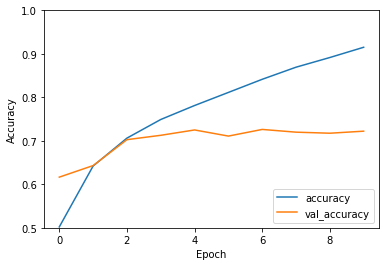

In [96]:
# Evaluar el modelo
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [97]:
print(test_acc)

0.7221999764442444


## Data Augmentation

In [100]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(32,
                                  32,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


## Dropout

In [123]:
model = Sequential([
#   data_augmentation,
#   layers.Rescaling(1./255),
  layers.Conv2D(32, (2, 2), activation='relu', input_shape=(32, 32, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (2, 2), activation='relu'),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(128, (2, 2), activation='relu'),
  layers.MaxPooling2D(2, 2),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(10, activation='softmax')
])

# Crear base convolucional
# model = models.Sequential()
# model.add(layers.Conv2D(32, (2, 2), activation='relu', input_shape=(32, 32, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (2, 2), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (2, 2), activation='relu'))
# model.add(layers.Flatten())
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dense(10, activation='softmax'))

In [124]:
# Mostrar arquitectura
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_61 (Conv2D)          (None, 31, 31, 32)        416       
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_62 (Conv2D)          (None, 14, 14, 64)        8256      
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_63 (Conv2D)          (None, 6, 6, 128)         32896     
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 3, 3, 128)      

In [125]:
# Compilar y entrenar el modelo
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.5039 - accuracy: 0.4549 - val_loss: 1.2602 - val_accuracy: 0.5514
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1498 - accuracy: 0.5915 - val_loss: 1.0562 - val_accuracy: 0.6338
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.9955 - accuracy: 0.6508 - val_loss: 0.9006 - val_accuracy: 0.6883
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8962 - accuracy: 0.6844 - val_loss: 0.8501 - val_accuracy: 0.7053
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8222 - accuracy: 0.7131 - val_loss: 0.8048 - val_accuracy: 0.7209
Epoch 6/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.7639 - accuracy: 0.7331 - val_loss: 0.7709 - val_accuracy: 0.7334
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.7161 - accuracy: 0.7494 - val_loss: 0.7592 - val_accuracy:

## Mostrar predicciones

El propósito de esta sección es visualizar los resultados de las predicciones para el set de datos de prueba (_test_images_).

Código base tomado como referencia de [tensor flow](https://www.tensorflow.org/tutorials/keras/classification?hl=es-419).

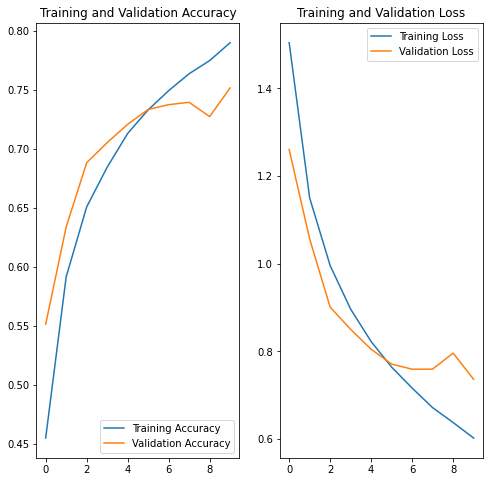

In [126]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [127]:
print(test_acc)

0.7221999764442444


In [119]:
# Guardamos las predicciones del modelo
predictions = model.predict(test_images)

313/313 [==============================] - 1s 2ms/step


In [91]:
# Funciones de ayuda para graficar niveles de confianza para cada una de las clases
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i][0], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label, class_names):
  predictions_array, true_label = predictions_array, true_label[i][0]
  plt.grid(False)
  plt.yticks(range(10))
  # plt.xticks([])
  thisplot = plt.barh([str(i) + '_' + class_j for i, class_j in enumerate(class_names)], 
                      predictions_array, color="#777777")
  plt.xlim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')
  plt.title('Probability')

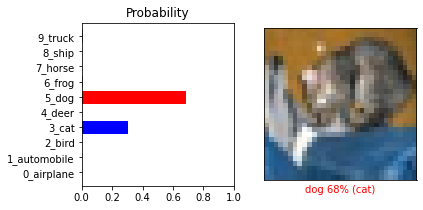

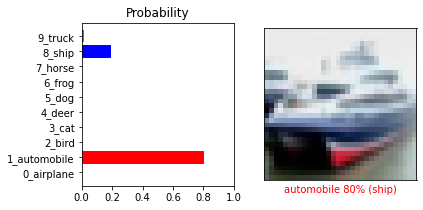

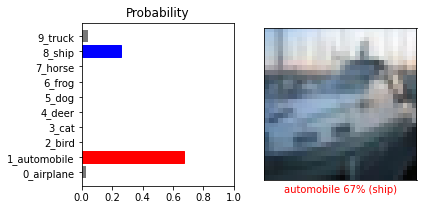

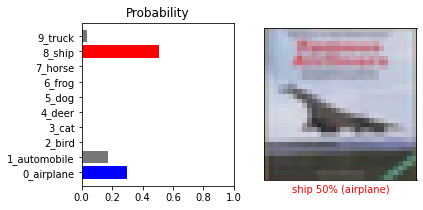

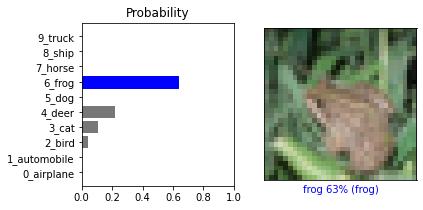

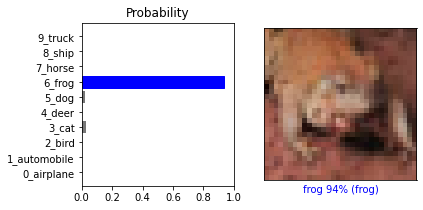

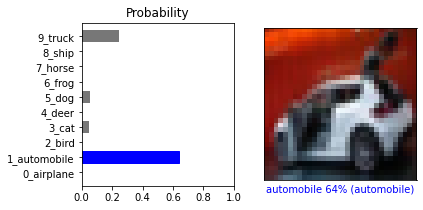

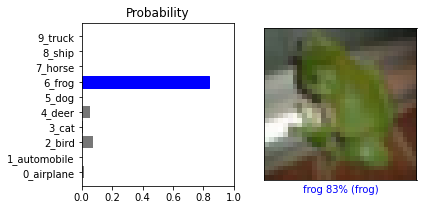

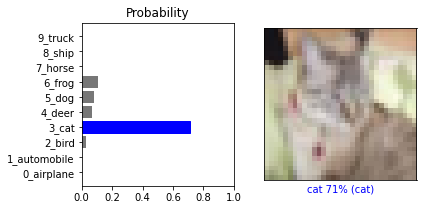

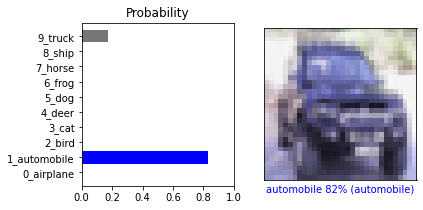

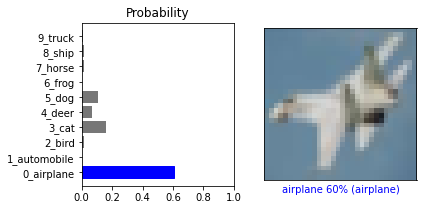

In [128]:
# Modificar i para mostrar los resultados para diferentes imagenes
# Barra roja indica la categoría equivocada (en caso de error), la barra azul es la clase real y las barras grises son el resto
# i = 7
for i in range(11):
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plot_value_array(i, predictions[i],  test_labels, class_names)
    plt.subplot(1,2,2)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.show()


# Ejercicio (por equipos)

1. Modificar la arquitectura de la red neuronal para tratar de mejorar la respuesta alcanzada en este notebook (baseline). Entre los cambios que se pueden realizar está el cambio en la organización de las capas y el ajuste de hiperparámetros como el número de canales en ciertas capas, el tamaño del kernel, funciones de activación, etc.

2. Calcular y documentar las métricas de Matriz de Confusión, Exactitud, Precisión, Sensibilidad, Especificidad y MCC (_Matthews Correlation Coefficient_) tanto para el baseline como para la respuesta mejorada después de realizar los cambios en la arquitectura.

3. Entrega un Jupyter Notebook que contenga la arquitectura baseline y donde se realizaron los cambios en la arquitectura junto con el cálculo de las métricas mencionadas.

4. Entrega una presentación por equipos en donde describas el tipo de cambios que se le hicieron a la red neuronal y se muestre el análisis de las métricas.

# Discusión (opcional)
* ¿Cómo opera una función de activación ReLU? ¿Existen otras funciones de activación?
    - Da de salida el input si es positivo, de otra manera da cero.
    - Existen otras, como las sigmoides y Tanh, pero dan problemas como el del [vanishing gradient problem](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/)
* ¿Existen recomendaciones generales sobre el tamaño de los kernels en la capa convolucional?
    - Sí, depende de los inputs y los outputs
* ¿Existen estructuras recomendadas para detección de cierto tipo de objetos vs. detección de caras por ejemplo?